* PassengerId adalah id pada row, maka tidak ada pengaruh terhadap target yang dicari
* Survived adalah target yang akan diprediksi, nilai 0 = Not Survived dan nilai 1 = Survived
* Pclass (Passenger Class) adalah kategori level sosial ekonomi penumpang dengan nilai (1, 2 atau 3):
  * 1 = Upper Class
  * 2 = Middle Class
  * 3 = Lower Class
* Name, Sex dan Age merupakan data self-explanatory
* SibSp adalah jumlah saudara dari penumpang
* Parch adalah jumlah Orang Tua dan anak dari penumpang
* Ticket adalah jumlah tiket penumpang
* Fare adalah tarif yang di kenakan kepada penumpang
* Cabin adalah nomor kabin penumpang
* Embarked adalah pelabuhan pemberangkatan ada 3 pelabuhan (C, Q atau S):
  * C = Cherbourg
  * Q = Queenstown
  * S = Southampton

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [52]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_train = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_train.csv')
df_test = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_test.csv')
df_all = concat_df(df_train, df_test)
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 
dfs = [df_train, df_test]

# Exploring Data

In [53]:
print('data training example: ', df_train.shape[0])
print('data test example: ', df_test.shape[0])

print('data x train shape: ', df_train.shape)
print('data y train shape :', df_train.Survived.shape[0])

print('data x test shape :', df_test.shape)
print('data y test shape :', df_test.shape[0])

# nama columns
print(df_train.columns)
print(df_test.columns)

data training example:  891
data test example:  418
data x train shape:  (891, 12)
data y train shape : 891
data x test shape : (418, 11)
data y test shape : 418
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [54]:
# missing value

df_train.info(memory_usage=False)
print(df_train.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7  

In [55]:
# correlation value
df_train_corr = df_train.corr().abs()
df_train_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.005007,0.035144,0.036847,0.057527,0.001652,0.012658
Survived,0.005007,1.000000,0.338481,0.077221,0.035322,0.081629,0.257307
Pclass,0.035144,0.338481,1.000000,0.369226,0.083081,0.018443,0.549500
Age,0.036847,0.077221,0.369226,1.000000,0.308247,0.189119,0.096067
SibSp,0.057527,0.035322,0.083081,0.308247,1.000000,0.414838,0.159651
Parch,0.001652,0.081629,0.018443,0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,0.549500,0.096067,0.159651,0.216225,1.000000


melalui table correlation diatas dapat diambil kesimpulan
  * survived memiliki hubungan dengan Pclass, Fare
  * Age memiliki hubungan dengan Plass, SibSp, Parch

kesimpulannya kebanyakan orang selamat di Pclass atas dan umur seseorang dapat dikatakan membawa seseorang


In [56]:
for df in dfs:
  print('{}'.format(df.name))
  print('{} missing values\n'.format(df.isnull().sum()))

Training Set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 missing values

Test Set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 missing values



# fill missing value

In [57]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df_all['Embarked'] = df_all['Embarked'].fillna('S')
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

# Exploring Data

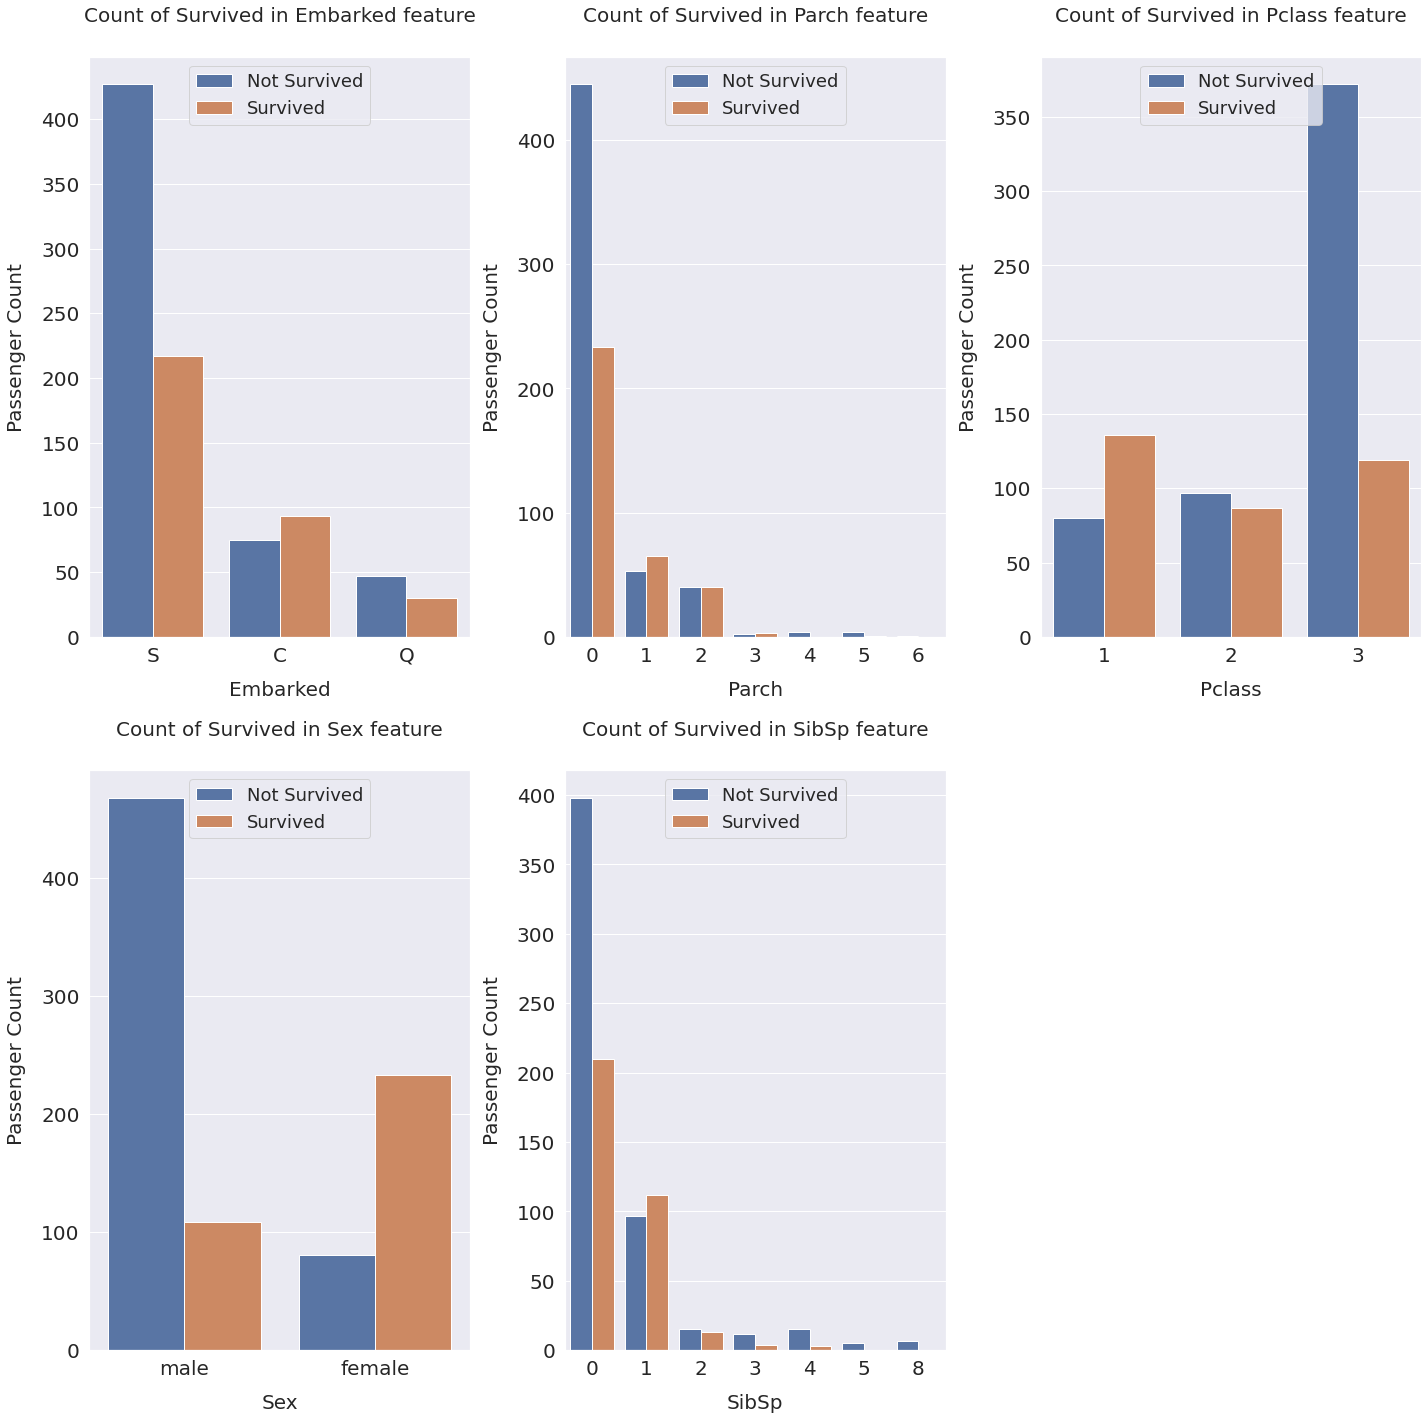

In [58]:
cat_feature = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_feature, 1):
  plt.subplot(2, 3, i)
  sns.countplot(x=feature, hue='Survived', data=df_train)

  plt.xlabel('{}'.format(feature), size=20, labelpad=15)
  plt.ylabel('Passenger Count', size=20, labelpad=15)
  plt.tick_params(axis='x', labelsize=20)
  plt.tick_params(axis='y', labelsize=20)

  plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size':18})
  plt.title('Count of Survived in {} feature'.format(feature), size=20, y=1.05)

plt.tight_layout()
plt.show()

In [59]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


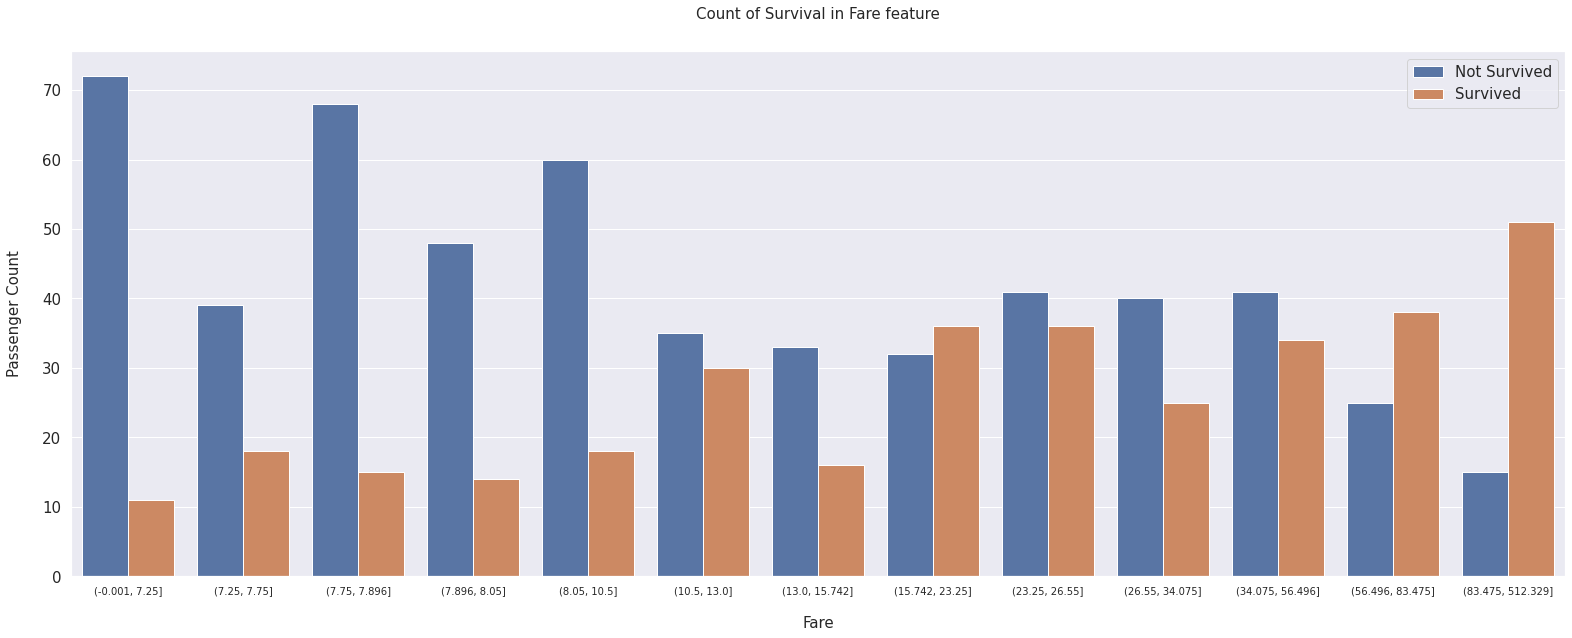

In [60]:
# Membagi Fare menjadi 13 bagian
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22,9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size':15})
plt.title('Count of Survival in {} feature'.format('Fare'), size=15, y=1.05)
plt.tight_layout()
plt.show()

# Feature Engineering

membuat feature atau table baru

Fitur pertama yang kita buat adalah Family_Size, sesuai namanya ini adalah gabungan dari Parent, Children, Sibling, dan Spouse. Lalu kita tambahkan 1 dengan asumsi menghitung diri orang itu juga.

In [61]:
df_all['Family_size'] = df_all['SibSp'] + df_all['Parch'] + 1

In [62]:
df_all['Family_size'].unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11])

Text(0.5, 1.05, 'Survival Counts in Family Size After Grouping')

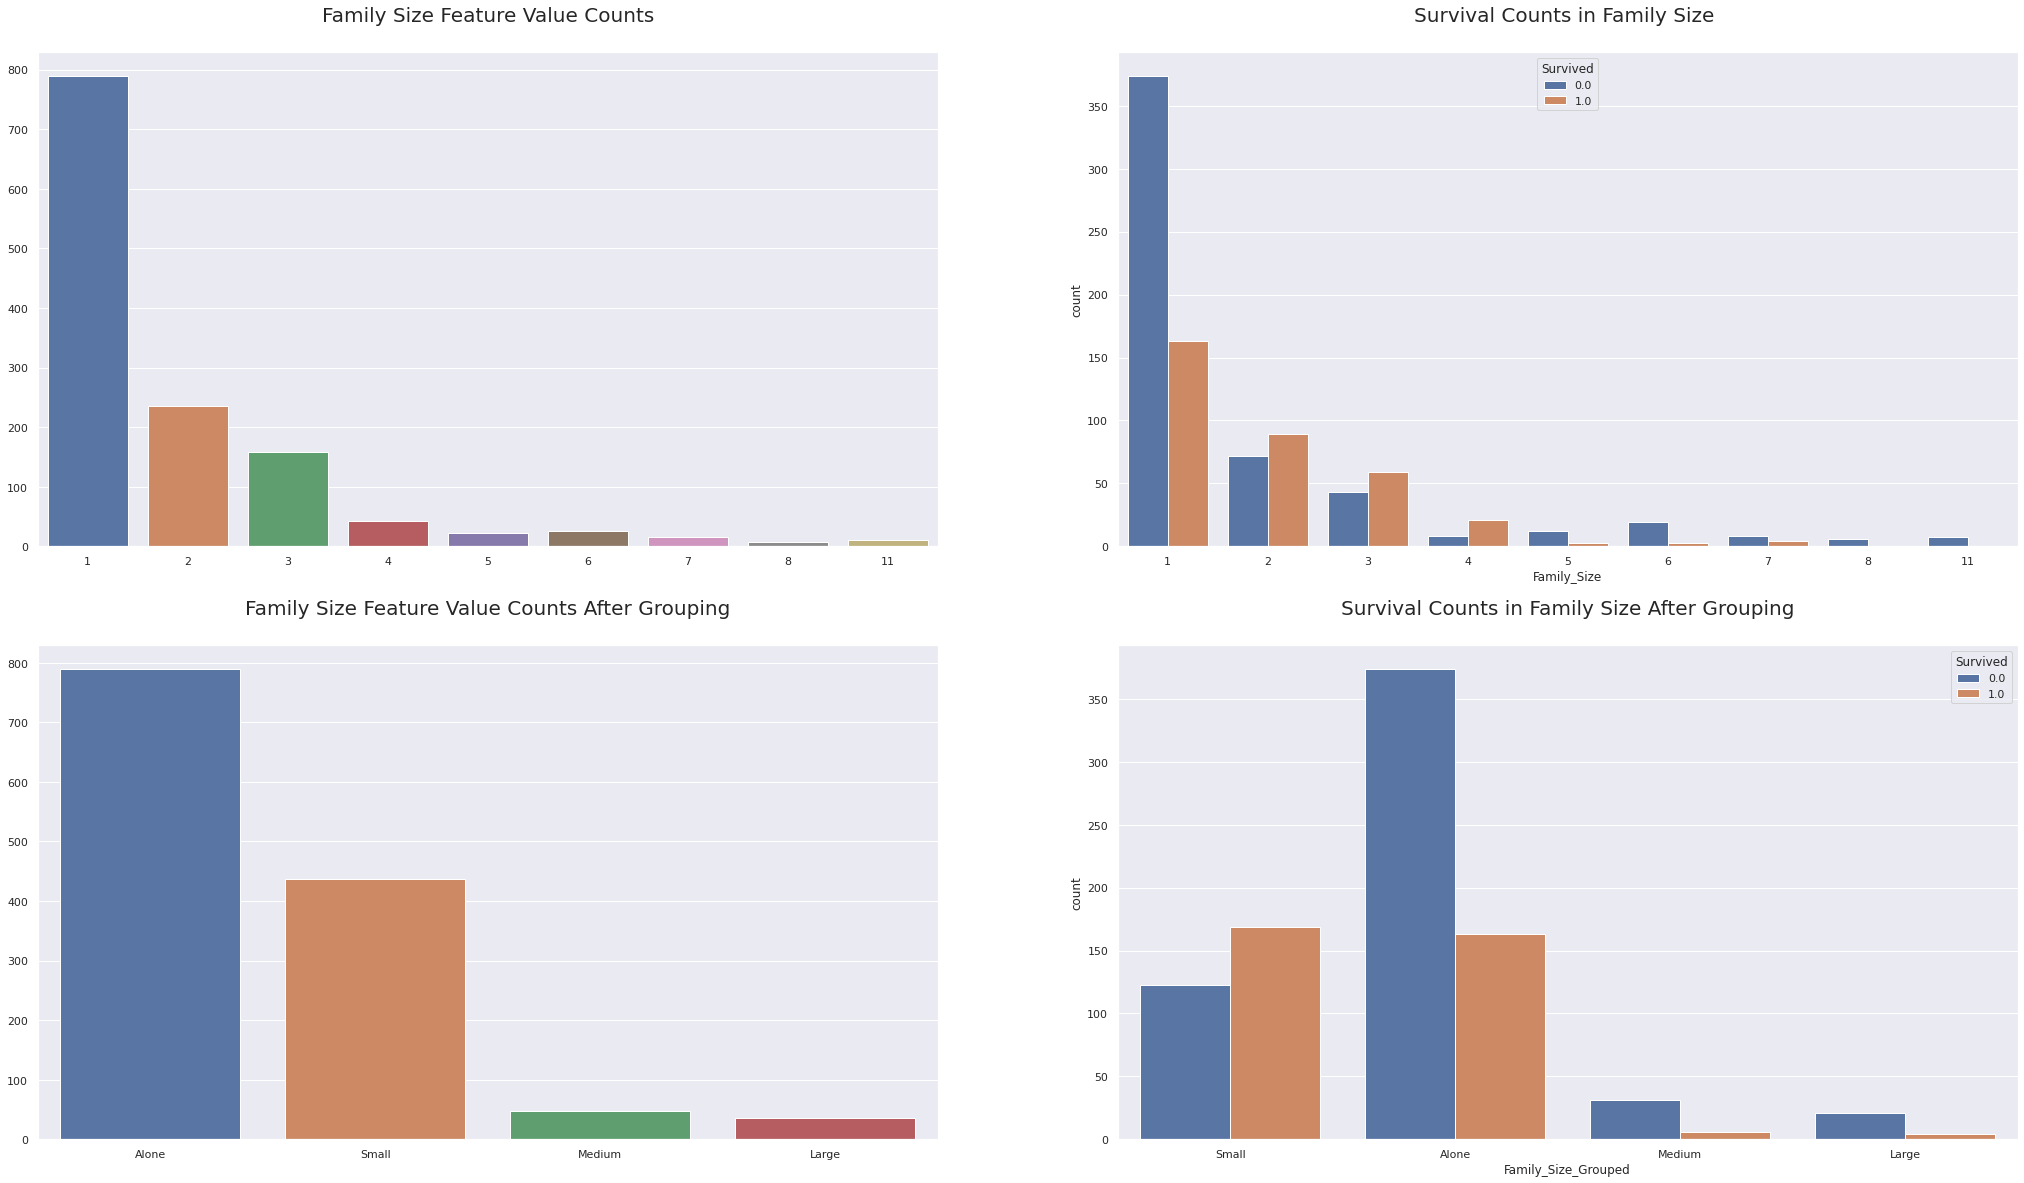

In [63]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)


## feature engineer 2
Kita buat feature baru bernama Ticket_Frequency dengan nilai gabungan dari Ticket yang sama. Contoh sebelumnya akan bernilai 6, karena ada 6 ticket yang sama dalam data kita.

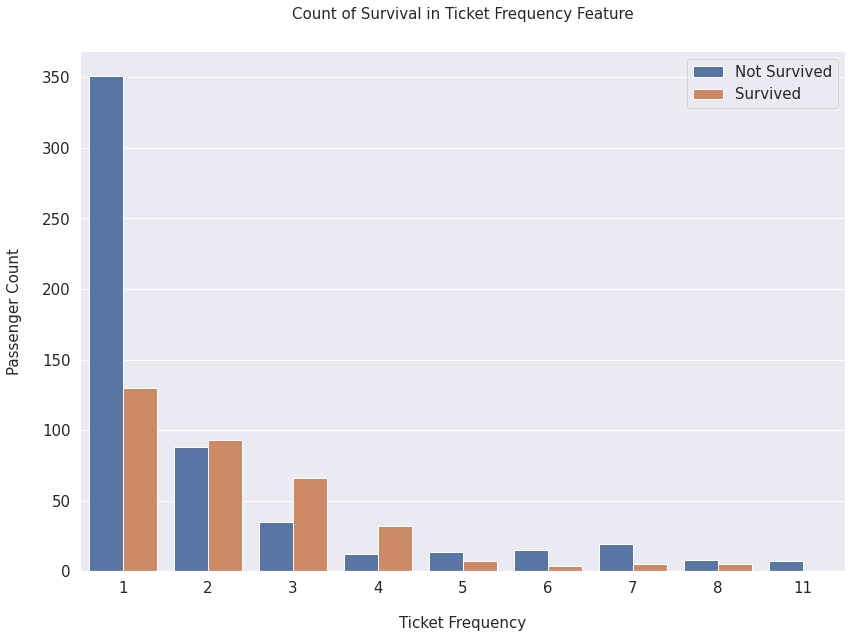

In [64]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)
plt.tight_layout()
plt.show()

# Feature engineering 3
mengambil jabatannya saja dengan mengambil kata setelah "," (koma) dan sebelum "." (titik). Fungsi .split() akan membagi kalimat menjadi beberapa kata dengan keyword tertentu, dan dapat diambil dengan index [ ]

In [69]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

print(df_all['Title'].unique())

df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

# df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
# df_all['Is_Married'] = 0
# df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

print(df_all['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Feature Engineer 4
Bagian ini adalah bagian mengubah ['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'] akan kita ubah menjadi 'Miss/Mrs/Ms' ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'] menjadi 'Dr/Military/Noble/Clergy'

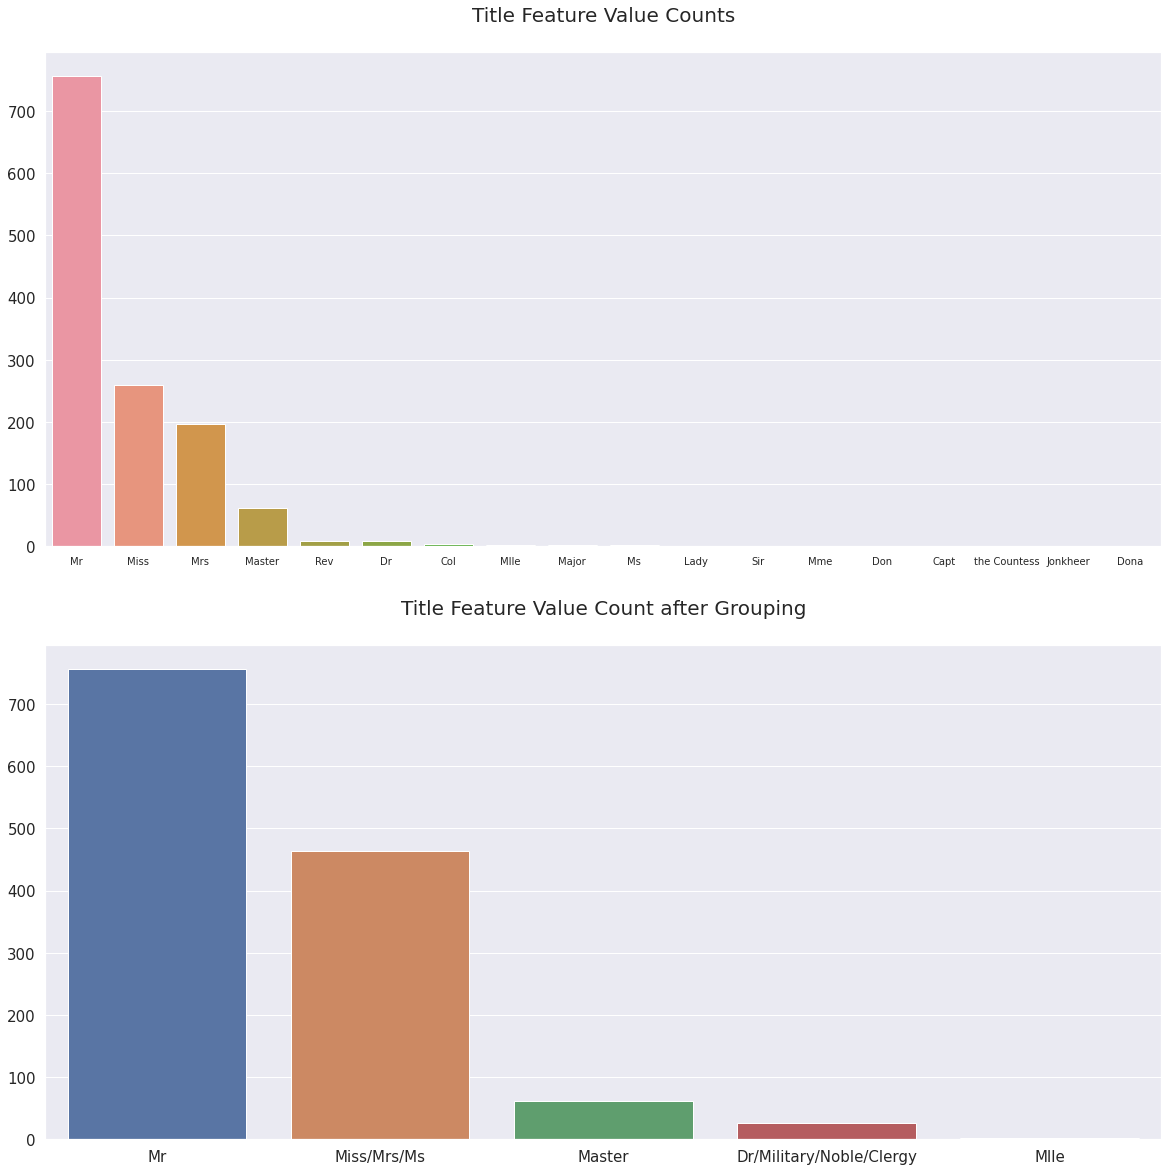

In [70]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):
  axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

# Rename Value
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs', 'Ms', 'Mile', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Count after Grouping', size=20, y=1.05)

plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(style="darkgrid")

# def concat_df(train_data, test_data):
#     return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

# df_train = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_train.csv')
# df_test = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/challenge/feature-engineering/titanic_test.csv')
# df_all = concat_df(df_train, df_test)
# df_train.name = 'Training Set'
# df_test.name = 'Test Set'
# df_all.name = 'All Set' 
# dfs = [df_train, df_test]

# age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']
# df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
# df_all['Embarked'] = df_all['Embarked'].fillna('S')
# med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# df_all['Fare'] = df_all['Fare'].fillna(med_fare)
# df_all['Fare'] = pd.qcut(df_all['Fare'], 13)
# df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

# family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
# df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)
# df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')
# df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
# df_all['Is_Married'] = 0
# df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1


# # Ketikkan kode yang dicontohkan di sini
# fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
# sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

# axs[0].tick_params(axis='x', labelsize=10)
# axs[1].tick_params(axis='x', labelsize=15)

# for i in range(2):
# 	axs[i].tick_params(axis='y', labelsize=15)

# axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

# df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
# df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

# sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
# axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)
# plt.tight_layout()
# plt.show()

# Modeling hasil feature 1
apakah benar kita bisa menaikkan akurasi modelnya?

Meningkatkan akurasi dari model kita dengan feature

In [76]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Split data ke train dan test

df_train = df_all[:890]
df_test = df_all[891:]
dfs = [df_train, df_test]


# preprocessing LabelEncoder untk non numeric data
non_numeric_features = ['Embarked', 'Sex', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
  for features in non_numeric_features:
    df[features] = LabelEncoder().fit_transform(df[features])

# preprocessing OneHotEncoder untuk mengubah kategori menjadi One Hot atau menjadi beberapa category
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
  for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols=['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)
  
df_train = pd.concat([df_train, *encoded_features[:5]], axis=1)
df_test = pd.concat([df_test, *encoded_features[5:]], axis=1)

<ipython-input-76-495101d7cd3a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = LabelEncoder().fit_transform(df[features])
<ipython-input-76-495101d7cd3a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = LabelEncoder().fit_transform(df[features])
<ipython-input-76-495101d7cd3a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

# Modeling Feature Engineer part 2

In [79]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived', 'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Fare,Is_Married,...,Pclass_3,Sex_1,Sex_2,SibSp,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4,Title_5
0,28,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,...,1.0,0.0,1.0,1,1,0.0,0.0,0.0,0.0,1.0
1,52,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11,1,...,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0,0.0
2,34,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,...,1.0,1.0,0.0,0,1,0.0,0.0,1.0,0.0,0.0
3,48,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10,1,...,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0,0.0
4,48,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,...,1.0,0.0,1.0,0,1,0.0,0.0,0.0,0.0,1.0


# Modeling Feature Engineer part 3

In [83]:
x_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
x_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols)) 

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))

x_train shape: (890, 23)
y_train shape: (890,)
x_test shape: (418, 22)


# Modeling Feature Engineer part 4
menggunakan RandomForesClassifier dan menghitung accuracy menggunakan cross_val_score

In [86]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(criterion='gini',
                                      n_estimators=1100,
                                      max_depth=5,
                                      min_samples_split=4,
                                      min_samples_leaf=5,
                                      max_features='auto',
                                      oob_score=True,
                                      random_state=50)
random_forest.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=5, max_features='auto', min_samples_leaf=5,
                       min_samples_split=4, n_estimators=1100, oob_score=True,
                       random_state=50)

In [88]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest, x_train, y_train, cv=10, scoring = 'accuracy')

print('Scores:', scores)
print('mean:', scores.mean())
print('standard deviation:', scores.std())

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Scores: [0.84269663 0.86516854 0.7752809  0.86516854 0.84269663 0.80898876
 0.83146067 0.78651685 0.86516854 0.85393258]
mean: 0.8337078651685392
standard deviation: 0.03129974893749239


# Modeling tanpa feature Engineer 1

In [92]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1308 non-null   int64  
 1   Embarked_1             1308 non-null   float64
 2   Embarked_2             1308 non-null   float64
 3   Embarked_3             1308 non-null   float64
 4   Family_Size_Grouped_1  1308 non-null   float64
 5   Family_Size_Grouped_2  1308 non-null   float64
 6   Family_Size_Grouped_3  1308 non-null   float64
 7   Family_Size_Grouped_4  1308 non-null   float64
 8   Fare                   1308 non-null   int64  
 9   Is_Married             1308 non-null   int64  
 10  Parch                  1308 non-null   int64  
 11  Pclass_1               1308 non-null   float64
 12  Pclass_2               1308 non-null   float64
 13  Pclass_3               1308 non-null   float64
 14  Sex_1                  1308 non-null   float64
 15  Sex_

In [94]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived','Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'Title','Family_Size_Grouped_1', 'Family_Size_Grouped_2', 'Family_Size_Grouped_3', 'Family_Size_Grouped_4','Ticket_Frequency', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Is_Married']

df_all.drop(columns=drop_cols, inplace=True)

print(df_all.head())

# processing
x_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
x_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('x_train shape: {}'.format(x_train.shape))
print('y_test shape: {}'.format(y_test.shape))
print('x_test shape: {}'.format(x_test.shape))

   Age  Embarked_1  Embarked_2  Embarked_3  Fare  Parch  Pclass_1  Pclass_2  \
0   28         0.0         0.0         1.0     0      0       0.0       0.0   
1   52         1.0         0.0         0.0    11      0       1.0       0.0   
2   34         0.0         0.0         1.0     3      0       0.0       0.0   
3   48         0.0         0.0         1.0    10      0       1.0       0.0   
4   48         0.0         0.0         1.0     3      0       0.0       0.0   

   Pclass_3  Sex_1  Sex_2  SibSp  Title_5  
0       1.0    0.0    1.0      1      1.0  
1       0.0    1.0    0.0      1      0.0  
2       1.0    1.0    0.0      0      0.0  
3       0.0    1.0    0.0      1      0.0  
4       1.0    0.0    1.0      0      1.0  
X_train shape: (890, 13)
y_train shape: (890,)
X_test shape: (418, 12)


In [95]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(criterion='gini',
                                       n_estimators=1100,
                                       max_depth=5,
                                       min_samples_split=4,
                                       min_samples_leaf=5,
                                       max_features='auto',
                                       oob_score=True,
                                       random_state=50)
random_forest.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=5, max_features='auto', min_samples_leaf=5,
                       min_samples_split=4, n_estimators=1100, oob_score=True,
                       random_state=50)

In [96]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(random_forest, x_train, y_train, cv=10, scoring='accuracy')

print(scores)
print(scores.mean())
print(scores.std())

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

[0.80898876 0.84269663 0.76404494 0.87640449 0.85393258 0.78651685
 0.82022472 0.78651685 0.83146067 0.85393258]
0.8224719101123595
0.03400617067510461
